In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
file_path = "C://Users//likit//Downloads//Mock data sheet Telangana_Handloom_Textiles_1000_.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Select relevant columns
df_selected = df[['Fabric Type', 'Fiber Blend', 'Dye Type', 'Dye Quality', 'Defects Detected']].copy()

# Convert 'Defects Detected' to binary classification
df_selected['Defects Detected'] = df_selected['Defects Detected'].apply(
    lambda x: 'Yes' if 'color' in str(x).lower() else 'No'
)

# Encoding categorical features
ordinal_features = ['Dye Quality']
categorical_features = ['Fabric Type', 'Fiber Blend', 'Dye Type']

ordinal_encoder = OrdinalEncoder()
df_selected[ordinal_features] = ordinal_encoder.fit_transform(df_selected[ordinal_features])

encoder = OneHotEncoder(sparse=False, drop="first")
X_encoded = encoder.fit_transform(df_selected[categorical_features])

X = pd.DataFrame(X_encoded)
X[ordinal_features] = df_selected[ordinal_features].reset_index(drop=True)
X.columns = X.columns.astype(str)

# Save the encoders
with open("ordinal_encoder.pkl", "wb") as f:
    pickle.dump(ordinal_encoder, f)
with open("onehot_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Save the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Encode target variable
df_selected['Defects Detected'] = df_selected['Defects Detected'].map({'No': 0, 'Yes': 1})
y = df_selected['Defects Detected']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train TabPFN Classifier
clf = TabPFNClassifier(device='cpu')
clf.fit(X_train, y_train)

# Save the model
with open("tabpfn_model.pkl", "wb") as f:
    pickle.dump(clf, f)

# Make predictions on the test set
y_pred_tabpfn = clf.predict(X_test)

# Evaluate the model
accuracy_tabpfn = accuracy_score(y_test, y_pred_tabpfn)
print("Accuracy of TabPFN classifier: {:.2f}%".format(accuracy_tabpfn * 100))
print('------------------------------------------------------------------')
print(classification_report(y_test, y_pred_tabpfn))

# Function to predict defect without user input

def predict_defect(fabric_type, fiber_blend, dye_type, dye_quality):
    user_input = pd.DataFrame([[fabric_type, fiber_blend, dye_type, dye_quality]], 
                               columns=['Fabric Type', 'Fiber Blend', 'Dye Type', 'Dye Quality'])
    
    # Load the encoders
    with open("ordinal_encoder.pkl", "rb") as f:
        loaded_ordinal_encoder = pickle.load(f)
    with open("onehot_encoder.pkl", "rb") as f:
        loaded_onehot_encoder = pickle.load(f)
    
    user_input[ordinal_features] = loaded_ordinal_encoder.transform(user_input[ordinal_features])
    user_encoded = loaded_onehot_encoder.transform(user_input[categorical_features])
    
    user_X = pd.DataFrame(user_encoded)
    user_X[ordinal_features] = user_input[ordinal_features].reset_index(drop=True)
    user_X.columns = user_X.columns.astype(str)
    
    # Load the scaler
    with open("scaler.pkl", "rb") as f:
        loaded_scaler = pickle.load(f)
    user_X_scaled = loaded_scaler.transform(user_X)
    
    # Load the model
    with open("tabpfn_model.pkl", "rb") as f:
        loaded_model = pickle.load(f)
    
    prediction = loaded_model.predict(user_X_scaled)
    return "Yes" if prediction[0] == 1 else "No"

# Example usage
fabric_type = "Warangal Cotton Durries"
fiber_blend = "100% Silk"
dye_type = "Chemical Dye"
dye_quality = "Low Fastness"

predicted_defect = predict_defect(fabric_type, fiber_blend, dye_type, dye_quality)
print("Predicted Defect:", predicted_defect)


C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy of CatBoost classifier: 81.33%
------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       244
           1       0.00      0.00      0.00        56

    accuracy                           0.81       300
   macro avg       0.41      0.50      0.45       300
weighted avg       0.66      0.81      0.73       300



C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Predicted Defect: No


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tabpfn import TabPFNClassifier

# Load the dataset
file_path = "C://Users//likit//Downloads//Mock data sheet Telangana_Handloom_Textiles_1000_.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Select relevant columns
df_selected = df[['Fabric Type', 'Fiber Blend', 'Dye Type', 'Dye Quality', 'Defects Detected']].copy()

# Convert 'Defects Detected' to binary classification
df_selected['Defects Detected'] = df_selected['Defects Detected'].apply(
    lambda x: 'Yes' if 'color' in str(x).lower() else 'No'
)

# Encoding categorical features
ordinal_features = ['Dye Quality']
categorical_features = ['Fabric Type', 'Fiber Blend', 'Dye Type']

ordinal_encoder = OrdinalEncoder()
df_selected[ordinal_features] = ordinal_encoder.fit_transform(df_selected[ordinal_features])

encoder = OneHotEncoder(sparse=False, drop="first")
X_encoded = encoder.fit_transform(df_selected[categorical_features])

X = pd.DataFrame(X_encoded)
X[ordinal_features] = df_selected[ordinal_features].reset_index(drop=True)
X.columns = X.columns.astype(str)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Encode target variable
df_selected['Defects Detected'] = df_selected['Defects Detected'].map({'No': 0, 'Yes': 1})
y = df_selected['Defects Detected']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train multiple classifiers
models = {
    "TabPFN": TabPFNClassifier(device='cpu'),
    "CatBoost": CatBoostClassifier(verbose=0),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "HGB": HistGradientBoostingClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier()
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {name} classifier: {accuracy * 100:.2f}%")
    print('------------------------------------------------------------------')
    print(classification_report(y_test, y_pred))

# Function to predict defect without user input
def predict_defect(model_name, fabric_type, fiber_blend, dye_type, dye_quality):
    user_input = pd.DataFrame([[fabric_type, fiber_blend, dye_type, dye_quality]], 
                               columns=['Fabric Type', 'Fiber Blend', 'Dye Type', 'Dye Quality'])
    
    user_input[ordinal_features] = ordinal_encoder.transform(user_input[ordinal_features])
    user_encoded = encoder.transform(user_input[categorical_features])
    
    user_X = pd.DataFrame(user_encoded)
    user_X[ordinal_features] = user_input[ordinal_features].reset_index(drop=True)
    user_X.columns = user_X.columns.astype(str)
    
    user_X_scaled = scaler.transform(user_X)
    
    prediction = models[model_name].predict(user_X_scaled)
    return "Yes" if prediction[0] == 1 else "No"

# Example usage
fabric_type = "Warangal Cotton Durries"
fiber_blend = "100% Silk"
dye_type = "Chemical Dye"
dye_quality = "Low Fastness"

for model in models.keys():
    predicted_defect = predict_defect(model, fabric_type, fiber_blend, dye_type, dye_quality)
    print(f"Predicted Defect ({model}):", predicted_defect)


C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training TabPFN...
Accuracy of TabPFN classifier: 81.33%
------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       244
           1       0.00      0.00      0.00        56

    accuracy                           0.81       300
   macro avg       0.41      0.50      0.45       300
weighted avg       0.66      0.81      0.73       300

Training CatBoost...


C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Accuracy of CatBoost classifier: 77.00%
------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       244
           1       0.07      0.02      0.03        56

    accuracy                           0.77       300
   macro avg       0.44      0.48      0.45       300
weighted avg       0.67      0.77      0.71       300

Training XGBoost...


C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\xgboost\core.py:158: UserWarning: [11:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of XGBoost classifier: 73.00%
------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       244
           1       0.14      0.09      0.11        56

    accuracy                           0.73       300
   macro avg       0.48      0.48      0.48       300
weighted avg       0.68      0.73      0.70       300

Training HGB...
Accuracy of HGB classifier: 77.67%
------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       244
           1       0.08      0.02      0.03        56

    accuracy                           0.78       300
   macro avg       0.44      0.48      0.45       300
weighted avg       0.67      0.78      0.72       300

Training DecisionTree...
Accuracy of DecisionTree classifier: 68.33%
-----------------------------------------------------

C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(


Predicted Defect (TabPFN): No
Predicted Defect (CatBoost): No
Predicted Defect (XGBoost): No
Predicted Defect (HGB): No
Predicted Defect (DecisionTree): No
Predicted Defect (RandomForest): No


C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training TabPFN...
Accuracy of TabPFN classifier: 81.33%
------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       244
           1       0.00      0.00      0.00        56

    accuracy                           0.81       300
   macro avg       0.41      0.50      0.45       300
weighted avg       0.66      0.81      0.73       300

Training CatBoost...


C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Accuracy of CatBoost classifier: 77.00%
------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       244
           1       0.07      0.02      0.03        56

    accuracy                           0.77       300
   macro avg       0.44      0.48      0.45       300
weighted avg       0.67      0.77      0.71       300

Training XGBoost...


C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\xgboost\core.py:158: UserWarning: [11:23:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of XGBoost classifier: 73.00%
------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       244
           1       0.14      0.09      0.11        56

    accuracy                           0.73       300
   macro avg       0.48      0.48      0.48       300
weighted avg       0.68      0.73      0.70       300

Training HGB...
Accuracy of HGB classifier: 77.67%
------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       244
           1       0.08      0.02      0.03        56

    accuracy                           0.78       300
   macro avg       0.44      0.48      0.45       300
weighted avg       0.67      0.78      0.72       300

Training DecisionTree...
Accuracy of DecisionTree classifier: 69.00%
-----------------------------------------------------

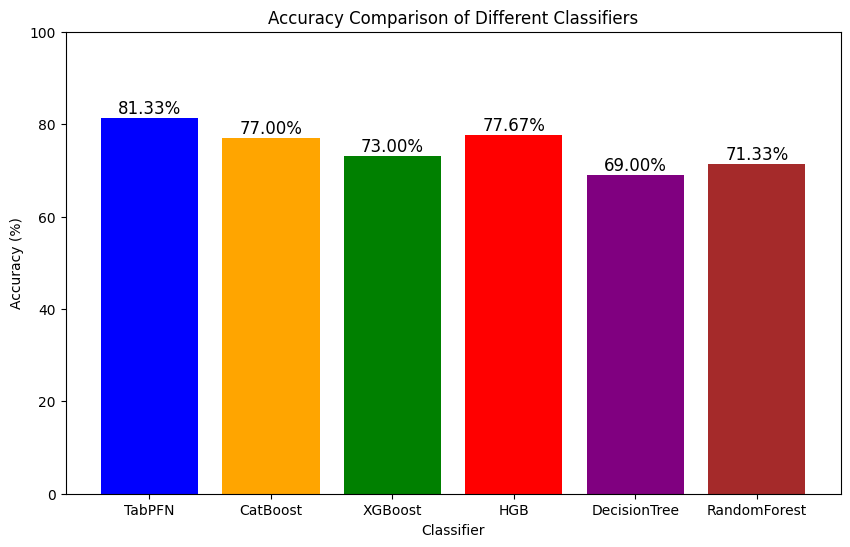

In [6]:
import matplotlib.pyplot as plt
accuracies = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy * 100
    print(f"Accuracy of {name} classifier: {accuracy * 100:.2f}%")
    print('------------------------------------------------------------------')
    print(classification_report(y_test, y_pred))

# Plot accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xlabel("Classifier")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison of Different Classifiers")
plt.ylim(0, 100)

# Adding text on bars
for i, (name, acc) in enumerate(accuracies.items()):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)

plt.show()


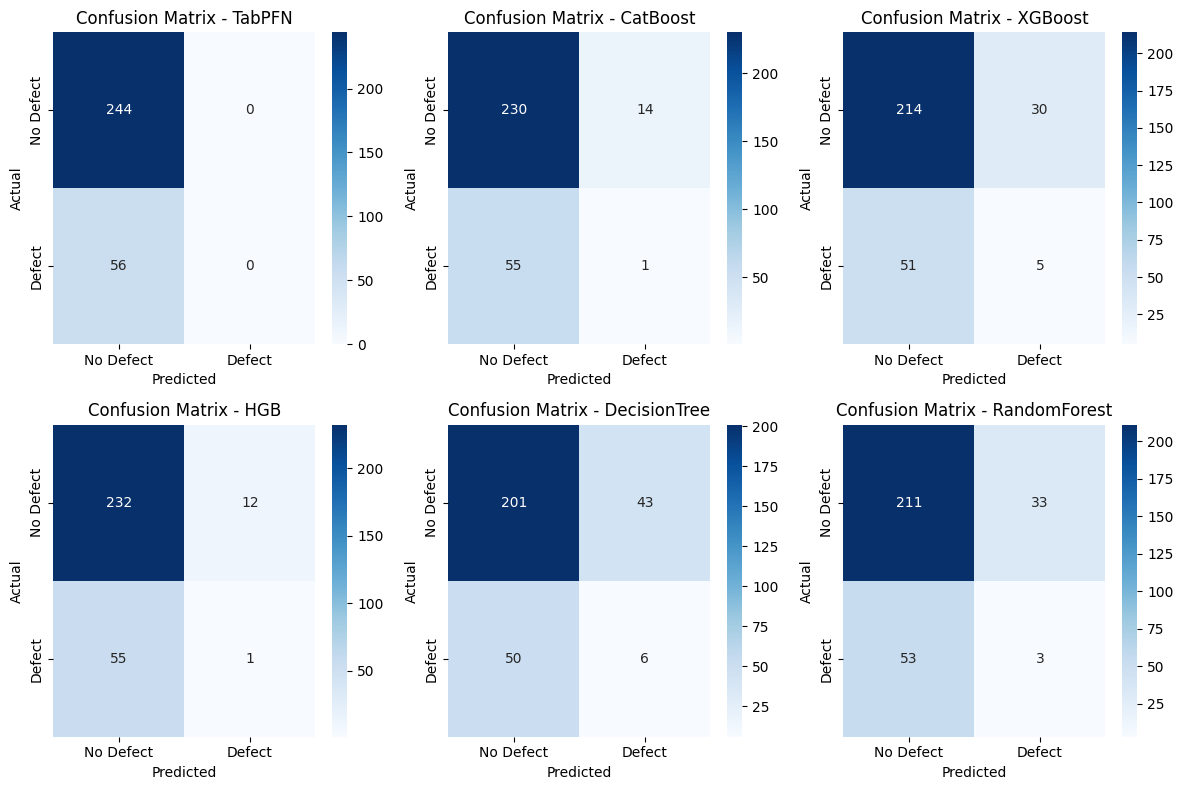

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 8))
for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    plt.subplot(2, 3, i + 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Defect', 'Defect'], yticklabels=['No Defect', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')

plt.tight_layout()
plt.show()


In [3]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(models["TabPFN"], X_test, y_test, scoring='accuracy', n_repeats=10, random_state=42)

# Extract feature importance values
feature_importance = result.importances_mean
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names, palette='viridis')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - TabPFN (Permutation Importance)")
plt.show()


KeyboardInterrupt: 

C:\Users\likit\anaconda3\envs\Skill_course_2-1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\likit\AppData\Local\Temp\ipykernel_2752\2851472480.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["80", "85", "90", "95", "100"])  # Adjust based on scale


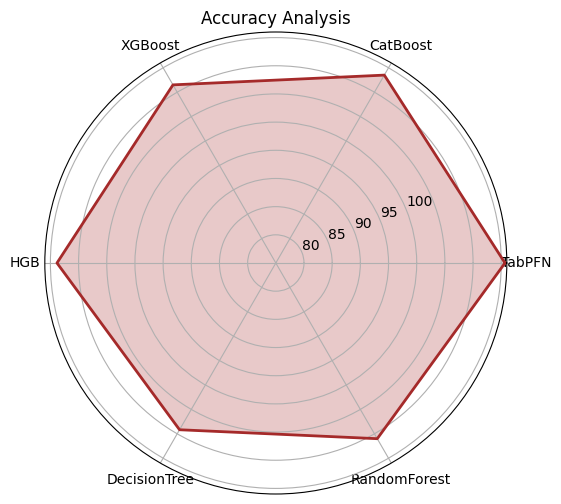

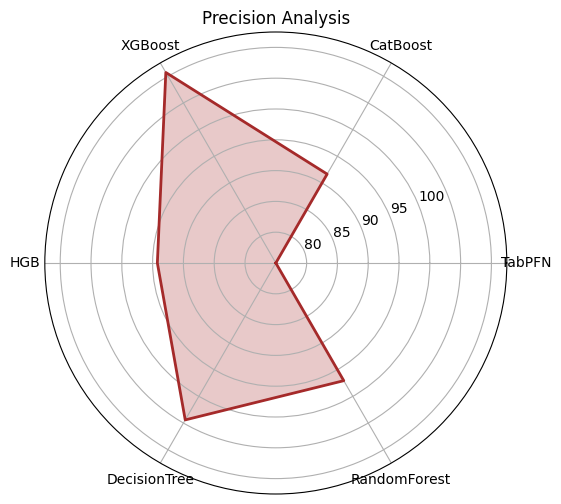

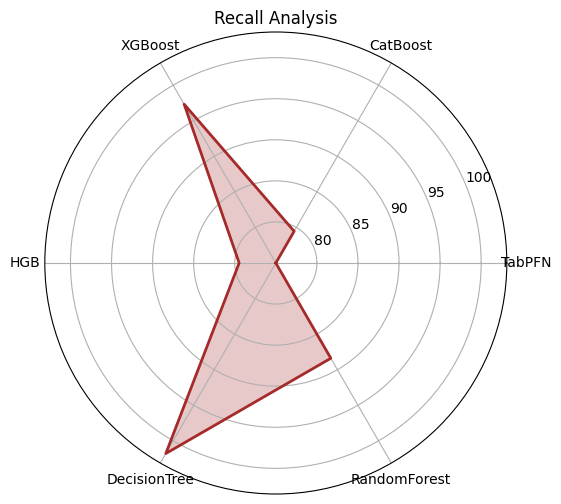

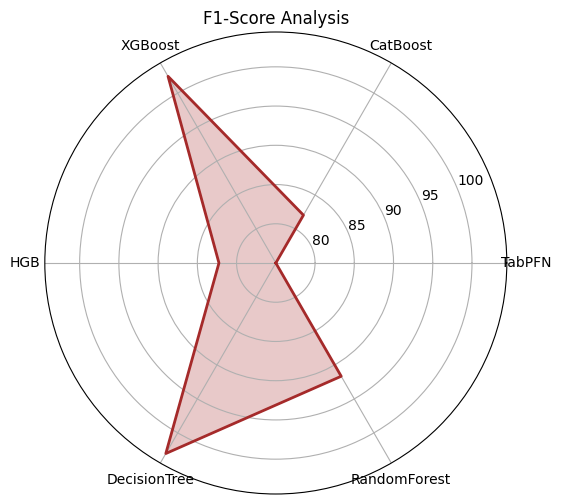

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize performance metric storage
performance_metrics = {
    "Accuracy": {},
    "Precision": {},
    "Recall": {},
    "F1-Score": {},
}

# Calculate metrics for each classifier
for name, model in models.items():
    y_pred = model.predict(X_test)
    
    performance_metrics["Accuracy"][name] = accuracy_score(y_test, y_pred) * 100
    performance_metrics["Precision"][name] = precision_score(y_test, y_pred) * 100
    performance_metrics["Recall"][name] = recall_score(y_test, y_pred) * 100
    performance_metrics["F1-Score"][name] = f1_score(y_test, y_pred) * 100

# Function to plot radar chart
def plot_radar_chart(metrics, title):
    labels = list(metrics.keys())
    values = list(metrics.values())
    
    num_vars = len(labels)
    
    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    # Close the circle
    values += values[:1]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    
    ax.fill(angles, values, color='brown', alpha=0.25)
    ax.plot(angles, values, color='brown', linewidth=2)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels(["80", "85", "90", "95", "100"])  # Adjust based on scale
    ax.set_title(title)
    
    plt.show()

# Generate radar charts for each metric
for metric_name, metric_values in performance_metrics.items():
    plot_radar_chart(metric_values, f"{metric_name} Analysis")


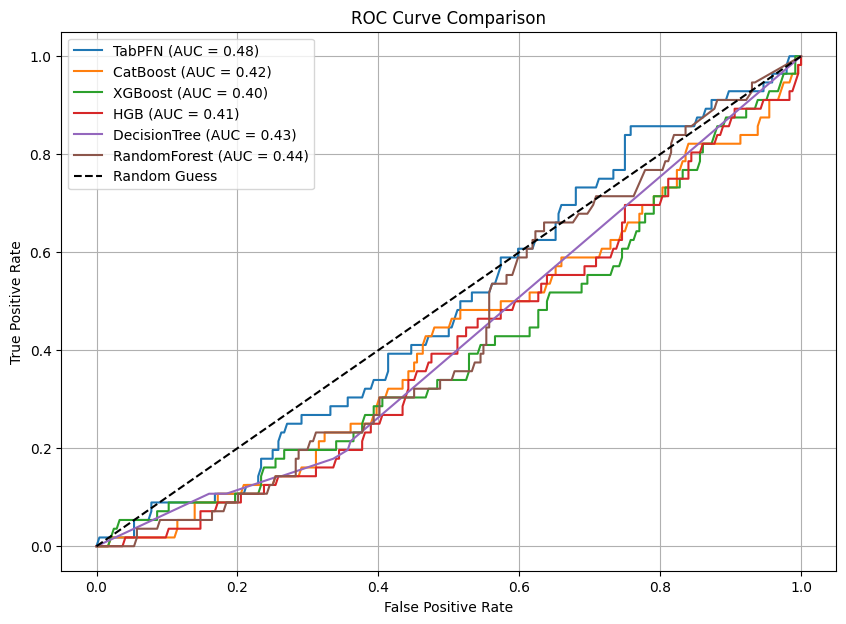

In [4]:
from sklearn.metrics import roc_curve, auc

# Plot ROC Curve for all classifiers
plt.figure(figsize=(10, 7))

for name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot reference diagonal
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()
